# Enron Data Person of Interest Project

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. In this project, you will play detective, and put your new skills to use by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. To assist you in your detective work, we've combined this data with a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.


In this project;

* The data were analyzed,
* NaN values in financial attributes were changed to zeros,
* Nan values in mailing features were changed to median value of related feature,
* Outliers were detected and removed from dataset,
* Features were selected based on the result of analysis in SelectKBest for classification (f_classif),
* New features were added to improve performance,
* NaiveBayes, RandomForest and AdaBoost classifiers were tried with different parameters and best classification method was chosen.


In [2]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
df = pd.DataFrame.from_dict(data_dict, orient='index')
df.head()


,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


There NaN values in some features of the dataset, for simplification of the analysis, these NaN strings shall be replaced with null values. 

In [4]:
df = df.replace('NaN', np.nan)

Before digging into dataset, I recognized that features of 'LOCKHART EUGENE E' is all NaNs. Therefore, in the first begining I have removed this row from the dataset.

In [5]:
df = df.drop('LOCKHART EUGENE E')

### Dataset Analysis & Wrangling

In [6]:
print "# of investigated people: ", df['poi'].count()
print "Person of interest distirbution: ", df.groupby('poi')['poi'].count()
print "Initial feature set: ", df.shape[1]

# of investigated people:  145
Person of interest distirbution:  poi
False    127
True      18
Name: poi, dtype: int64
Initial feature set:  21


There are 146 people, 18 of which is labeled as person of interes in the dataset. There are total of 21 features which are categorized into 2 groups, financial and mailing features.

In [7]:
print 'NaN values of features'
df.isnull().sum()

NaN values of features


salary                        50
to_messages                   59
deferral_payments            106
total_payments                20
exercised_stock_options       43
bonus                         63
restricted_stock              35
shared_receipt_with_poi       59
restricted_stock_deferred    127
total_stock_value             19
expenses                      50
loan_advances                141
from_messages                 59
other                         52
from_this_person_to_poi       59
poi                            0
director_fees                128
deferred_income               96
long_term_incentive           79
email_address                 34
from_poi_to_this_person       59
dtype: int64

As seen, most of the values in loan_advances feature is NA. Therefore, I removed this feature from dataset. Moreover, email_address can not be used in classification, so I removed this feature from the dataset.

In [8]:
del df['loan_advances']
del df['email_address']
df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,13868.0,2195.0,152.0,65.0,False,NaN,-3081055.0,304805.0,47.0
BADUM JAMES P,NaN,NaN,178980.0,182466.0,257817.0,NaN,NaN,NaN,NaN,257817.0,3486.0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477.0,566.0,NaN,916197.0,4046157.0,NaN,1757552.0,465.0,-560222.0,5243487.0,56301.0,29.0,864523.0,0.0,False,NaN,-5104.0,NaN,39.0
BAXTER JOHN C,267102.0,NaN,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,NaN,NaN,10623258.0,11200.0,NaN,2660303.0,NaN,False,NaN,-1386055.0,1586055.0,NaN
BAY FRANKLIN R,239671.0,NaN,260455.0,827696.0,NaN,400000.0,145796.0,NaN,-82782.0,63014.0,129142.0,NaN,69.0,NaN,False,NaN,-201641.0,NaN,NaN


Missing financial features can be filled with zeros since they are related with amount of money. 

In [9]:
financial_features = ['salary', 'deferral_payments', 'total_payments', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
df[financial_features] = df[financial_features].fillna(0)

Missing values in mailing features are very interesting since the possibility of those people to have received or sent any email is very low. If those values were filled with zeros, in classification phase those values may effect the success of the method. Therefore, filling with average values seems more logical. 

In [10]:
email_features = ['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
df[email_features] = df[email_features].fillna(df[email_features].median())
df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,13868.0,2195.0,152.0,65.0,False,0.0,-3081055.0,304805.0,47.0
BADUM JAMES P,0.0,1211.0,178980.0,182466.0,257817.0,0.0,0.0,740.5,0.0,257817.0,3486.0,41.0,0.0,8.0,False,0.0,0.0,0.0,35.0
BANNANTINE JAMES M,477.0,566.0,0.0,916197.0,4046157.0,0.0,1757552.0,465.0,-560222.0,5243487.0,56301.0,29.0,864523.0,0.0,False,0.0,-5104.0,0.0,39.0
BAXTER JOHN C,267102.0,1211.0,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,740.5,0.0,10623258.0,11200.0,41.0,2660303.0,8.0,False,0.0,-1386055.0,1586055.0,35.0
BAY FRANKLIN R,239671.0,1211.0,260455.0,827696.0,0.0,400000.0,145796.0,740.5,-82782.0,63014.0,129142.0,41.0,69.0,8.0,False,0.0,-201641.0,0.0,35.0


### Outlier Analysis

In [11]:
df.describe()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
count,1.450000e+02,145.000000,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,145.000000,1.450000e+02,1.450000e+02,1.450000e+02,145.000000,1.450000e+02,145.000000,1.450000e+02,1.450000e+02,1.450000e+02,145.000000
mean,3.683342e+05,1722.765517,4.418227e+05,4.380626e+06,4.211583e+06,1.342671e+06,1.761321e+06,999.072414,2.065786e+04,5.886335e+06,7.123619e+04,377.758621,5.894693e+05,27.710345,1.955643e+04,-3.854019e+05,6.692680e+05,52.731034
std,2.211001e+06,2029.355094,2.750583e+06,2.702539e+07,2.615843e+07,8.121319e+06,1.093676e+07,930.455922,1.444650e+06,3.636916e+07,4.341759e+05,1441.885356,3.694784e+06,78.611644,1.194559e+05,2.386279e+06,4.059716e+06,68.431460
min,0.000000e+00,57.000000,-1.025000e+05,0.000000e+00,0.000000e+00,0.000000e+00,-2.604490e+06,2.000000,-7.576788e+06,-4.409300e+04,0.000000e+00,12.000000,0.000000e+00,0.000000,0.000000e+00,-2.799289e+07,0.000000e+00,0.000000
25%,0.000000e+00,904.000000,0.000000e+00,1.025000e+05,0.000000e+00,0.000000e+00,3.246000e+04,589.000000,0.000000e+00,2.520550e+05,0.000000e+00,36.000000,0.000000e+00,6.000000,0.000000e+00,-3.834600e+04,0.000000e+00,25.000000
50%,2.106920e+05,1211.000000,0.000000e+00,9.665220e+05,6.087500e+05,3.000000e+05,3.605280e+05,740.500000,0.000000e+00,9.760370e+05,2.153000e+04,41.000000,9.720000e+02,8.000000,0.000000e+00,0.000000e+00,0.000000e+00,35.000000
75%,2.714420e+05,1607.000000,1.025900e+04,1.979596e+06,1.729541e+06,8.000000e+05,8.530640e+05,900.000000,0.000000e+00,2.332399e+06,5.394700e+04,52.000000,1.506560e+05,14.000000,0.000000e+00,0.000000e+00,3.753040e+05,41.000000
max,2.670423e+07,15149.000000,3.208340e+07,3.098866e+08,3.117640e+08,9.734362e+07,1.303223e+08,5521.000000,1.545629e+07,4.345095e+08,5.235198e+06,14368.000000,4.266759e+07,609.000000,1.398517e+06,0.000000e+00,4.852193e+07,528.000000


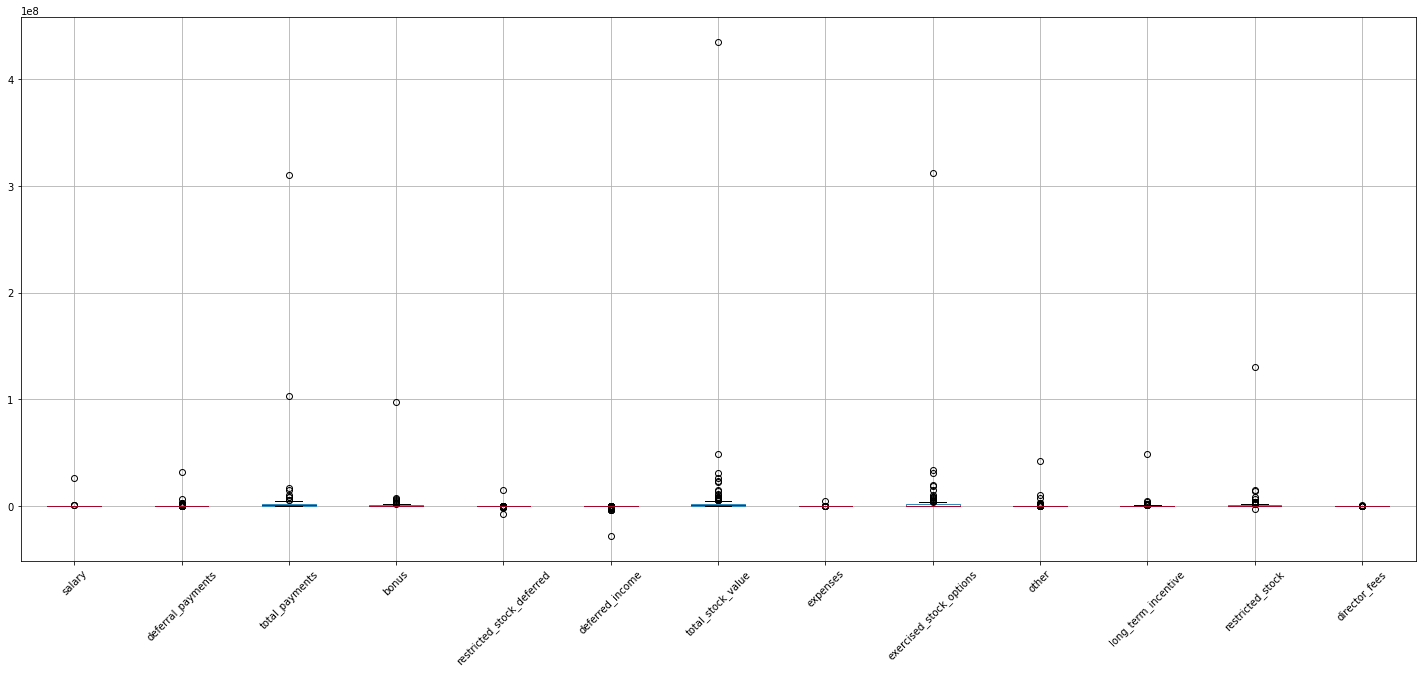

In [12]:
def plot_dataframe(dataframe):
    fig = plt.figure(figsize = (25,10))
    ax = fig.gca()
    pd.options.display.mpl_style = 'default'
    dataframe.boxplot(rot=45)
    
plot_dataframe(df[financial_features])


There are extreme outliers in the dataset which can be seen in total_stock_value, total_payments and excersized_stock_options. Let's see those outliers.


In [13]:
df[(df.total_stock_value > 4e8) | (df.total_payments > 3e8) | (df.exercised_stock_options > 3e8) ]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
TOTAL,26704229.0,1211.0,32083396.0,309886585.0,311764000.0,97343619.0,130322299.0,740.5,-7576788.0,434509511.0,5235198.0,41.0,42667589.0,8.0,False,1398517.0,-27992891.0,48521928.0,35.0


It is clearly seen that 'TOTAL' is an extreme outlier as expected since this is datapoint that shows the cumulative values in the dataset and does not represent a real user.

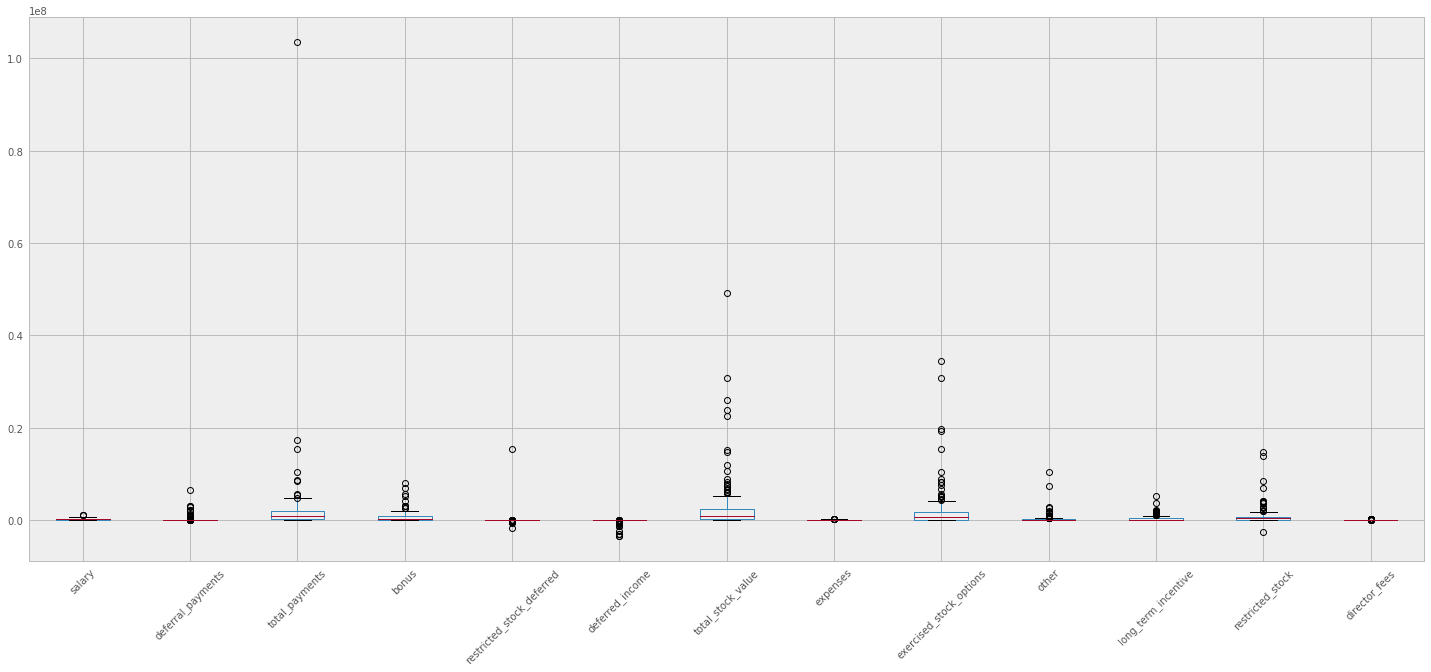

In [14]:
df = df.drop('TOTAL')
plot_dataframe(df[financial_features])

Now lets see mailing features whether if they contain any outliers.

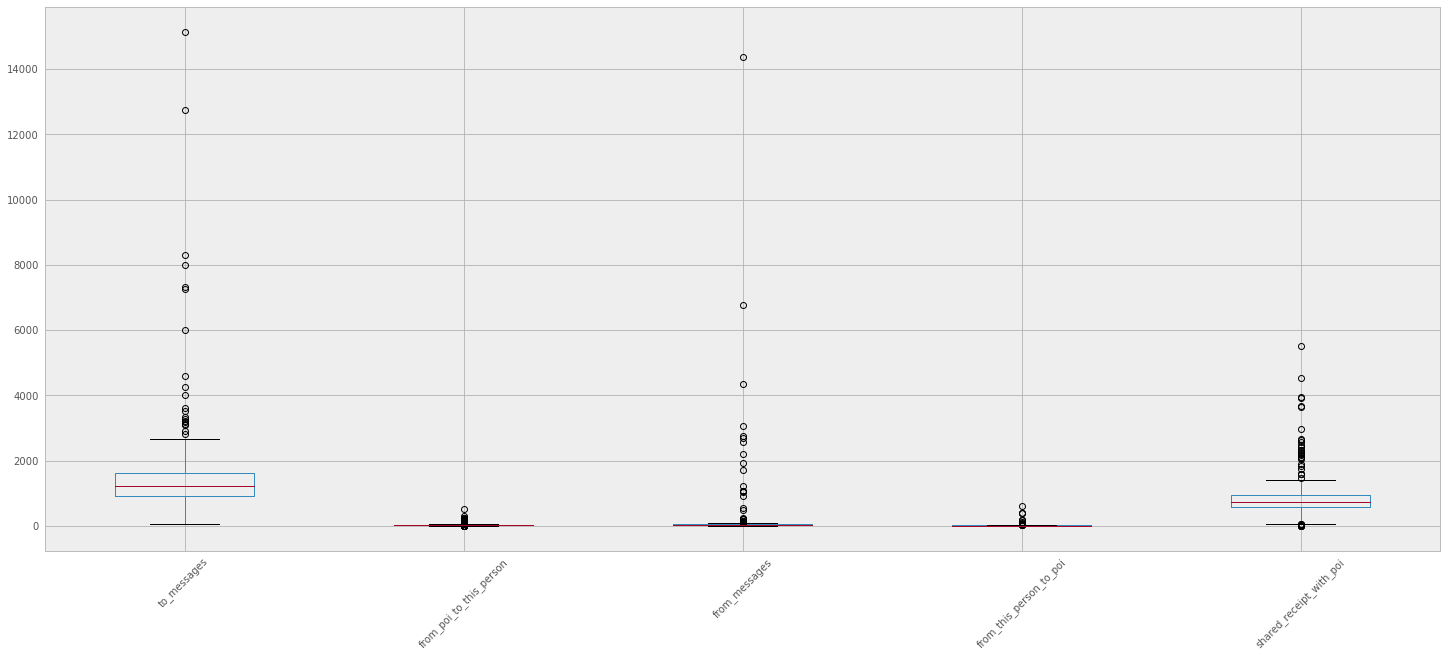

In [15]:
plot_dataframe(df[email_features])

In [16]:
df[(df.to_messages > 6000) | (df.from_messages > 1000) ]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,13868.0,2195.0,152.0,65.0,False,0.0,-3081055.0,304805.0,47.0
BECK SALLY W,231330.0,7315.0,0.0,969068.0,0.0,700000.0,126027.0,2639.0,0.0,126027.0,37172.0,4343.0,566.0,386.0,False,0.0,0.0,0.0,144.0
BELDEN TIMOTHY N,213999.0,7991.0,2144013.0,5501630.0,953136.0,5249999.0,157569.0,5521.0,0.0,1110705.0,17355.0,484.0,210698.0,108.0,True,0.0,-2334434.0,0.0,228.0
BUY RICHARD B,330546.0,3523.0,649584.0,2355702.0,2542813.0,900000.0,901657.0,2333.0,0.0,3444470.0,0.0,1053.0,400572.0,71.0,False,0.0,-694862.0,769862.0,156.0
DELAINEY DAVID W,365163.0,3093.0,0.0,4747979.0,2291113.0,3000000.0,1323148.0,2097.0,0.0,3614261.0,86174.0,3069.0,1661.0,609.0,True,0.0,0.0,1294981.0,66.0
HAEDICKE MARK E,374125.0,4009.0,2157527.0,3859065.0,608750.0,1150000.0,524169.0,1847.0,-329825.0,803094.0,76169.0,1941.0,52382.0,61.0,False,0.0,-934484.0,983346.0,180.0
HAYSLETT RODERICK J,0.0,2649.0,0.0,0.0,0.0,0.0,346663.0,571.0,0.0,346663.0,0.0,1061.0,0.0,38.0,False,0.0,0.0,0.0,35.0
HORTON STANLEY C,0.0,2350.0,3131860.0,3131860.0,5210569.0,0.0,2046079.0,1074.0,0.0,7256648.0,0.0,1073.0,0.0,15.0,False,0.0,0.0,0.0,44.0
KAMINSKI WINCENTY J,275101.0,4607.0,0.0,1086821.0,850010.0,400000.0,126027.0,583.0,0.0,976037.0,83585.0,14368.0,4669.0,171.0,False,0.0,0.0,323466.0,41.0
KEAN STEVEN J,404338.0,12754.0,0.0,1747522.0,2022048.0,1000000.0,4131594.0,3639.0,0.0,6153642.0,41953.0,6759.0,1231.0,387.0,False,0.0,0.0,300000.0,140.0


There are outliers in mailing features, some people may have received or sent much more emails than the others. I do not think they are extreme outliers, however removing those datapoints will effect the distribution of the dataset postively.

In [17]:
df = df[df.to_messages < 6000]
df = df[df.from_messages < 1000]

### Feature Selection & Engineering

After wrangling phase, some feature engineering is needed for more accurate and high-precision results from models. Therefore, I have added some new features to the dataset before feature selection phase.



I will engineer the mailing features as follows :
* to_message_poi_ratio = from_this_person_to_poi / to_messages
* from_message_poi_ratio = from_poi_to_this_person / from_messages
* message_in_out_ratio = from_messages / to_messages

In [18]:
df['to_message_poi_ratio'] = df['from_this_person_to_poi'] / df['to_messages']
df['from_message_poi_ratio'] = df['from_poi_to_this_person'] / df['from_messages']
df['message_in_out_ratio'] = df['from_messages'] / df['to_messages']


engineered_features = list(df)


def create_engineered_dataframe(engineered_f, data_frame):
    X_engineered = data_frame[engineered_features]
    return X_engineered

df_engineered = create_engineered_dataframe(engineered_features, df)

df_engineered.head()



,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,to_message_poi_ratio,from_message_poi_ratio,message_in_out_ratio
BADUM JAMES P,0.0,1211.0,178980.0,182466.0,257817.0,0.0,0.0,740.5,0.0,257817.0,...,0.0,8.0,False,0.0,0.0,0.0,35.0,0.006606,0.853659,0.033856
BANNANTINE JAMES M,477.0,566.0,0.0,916197.0,4046157.0,0.0,1757552.0,465.0,-560222.0,5243487.0,...,864523.0,0.0,False,0.0,-5104.0,0.0,39.0,0.000000,1.344828,0.051237
BAXTER JOHN C,267102.0,1211.0,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,740.5,0.0,10623258.0,...,2660303.0,8.0,False,0.0,-1386055.0,1586055.0,35.0,0.006606,0.853659,0.033856
BAY FRANKLIN R,239671.0,1211.0,260455.0,827696.0,0.0,400000.0,145796.0,740.5,-82782.0,63014.0,...,69.0,8.0,False,0.0,-201641.0,0.0,35.0,0.006606,0.853659,0.033856
BAZELIDES PHILIP J,80818.0,1211.0,684694.0,860136.0,1599641.0,0.0,0.0,740.5,0.0,1599641.0,...,874.0,8.0,False,0.0,0.0,93750.0,35.0,0.006606,0.853659,0.033856


After extending the feature set by adding new features using email features. I want to select the most important features to improve precision for models. I will use recursive feature selection and selectKbest to select the most descriptive features. 


Decision Tree Feature Selection
Optimal number of features : 6
['to_messages', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'to_message_poi_ratio']


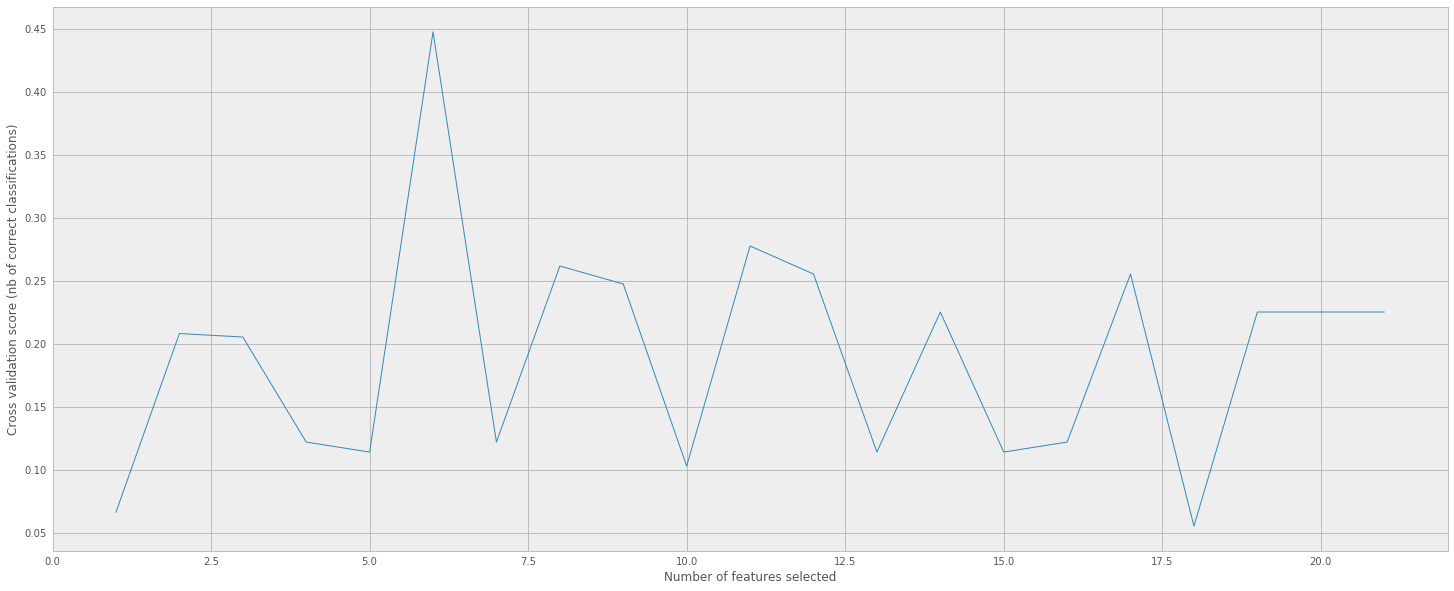


Random Forest Feature Selection
Optimal number of features : 16
['salary', 'to_messages', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'total_stock_value', 'expenses', 'from_messages', 'other', 'from_this_person_to_poi', 'long_term_incentive', 'from_poi_to_this_person', 'to_message_poi_ratio', 'from_message_poi_ratio', 'message_in_out_ratio']


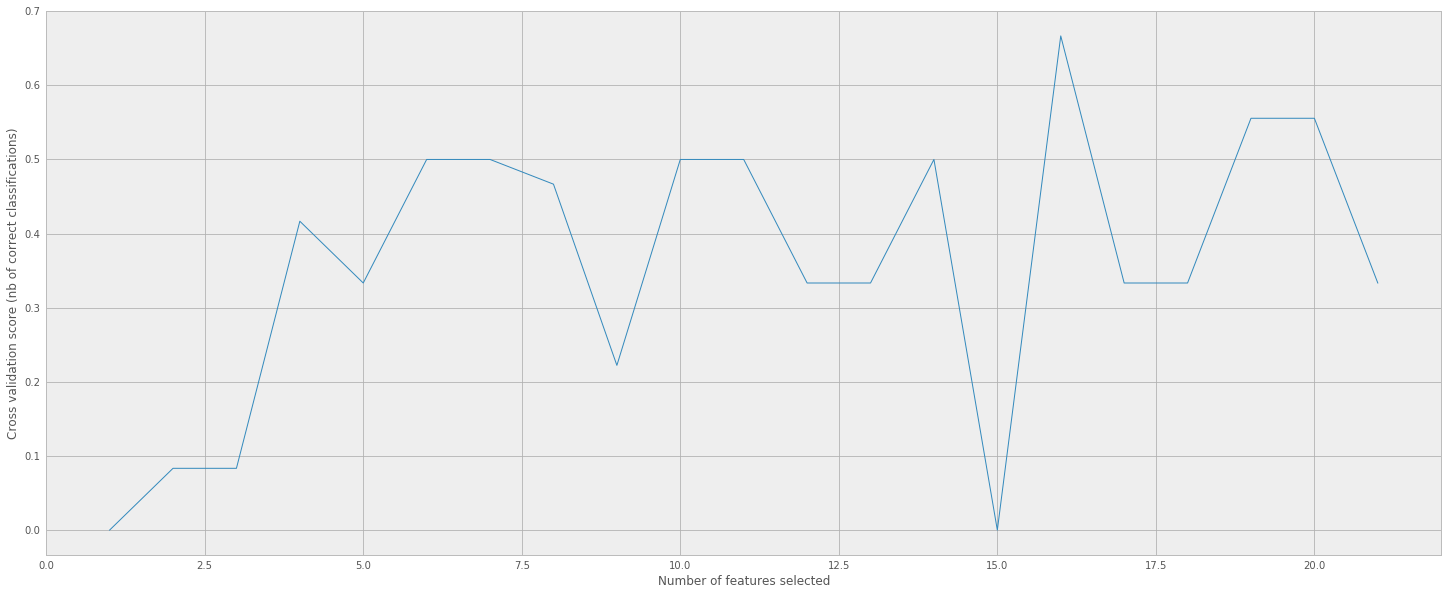

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFECV
from itertools import compress
from sklearn.cross_validation import cross_val_score, StratifiedKFold, StratifiedShuffleSplit

def feature_selection(classifer, dataframe, target):
    rfecv = RFECV(classifer, cv=StratifiedKFold(target),
          scoring='precision')
    rfecv.fit(dataframe, target)
    print("Optimal number of features : %d" % rfecv.n_features_)
    optimal_features = list(compress(list(dataframe), rfecv.support_))
    print optimal_features
    # Plot number of features VS. cross-validation scores
    plt.figure(figsize = (25,10))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    return optimal_features
    

    
target_feature = df_engineered.poi
df_poi_filtered = df_engineered.drop([ 'poi'], axis=1)

global optimal_features_decision_tree
global optimal_features_random_forest

print "Decision Tree Feature Selection"
clr = DecisionTreeClassifier(random_state=42)
optimal_features_decision_tree = feature_selection(clr, df_poi_filtered,target_feature)
print

print "Random Forest Feature Selection"
clr = RandomForestClassifier(random_state=42)
optimal_features_random_forest = feature_selection(clr, df_poi_filtered,target_feature)




Naive Bayes Feature Selection
['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'from_poi_to_this_person', 'to_message_poi_ratio', 'from_message_poi_ratio', 'message_in_out_ratio']


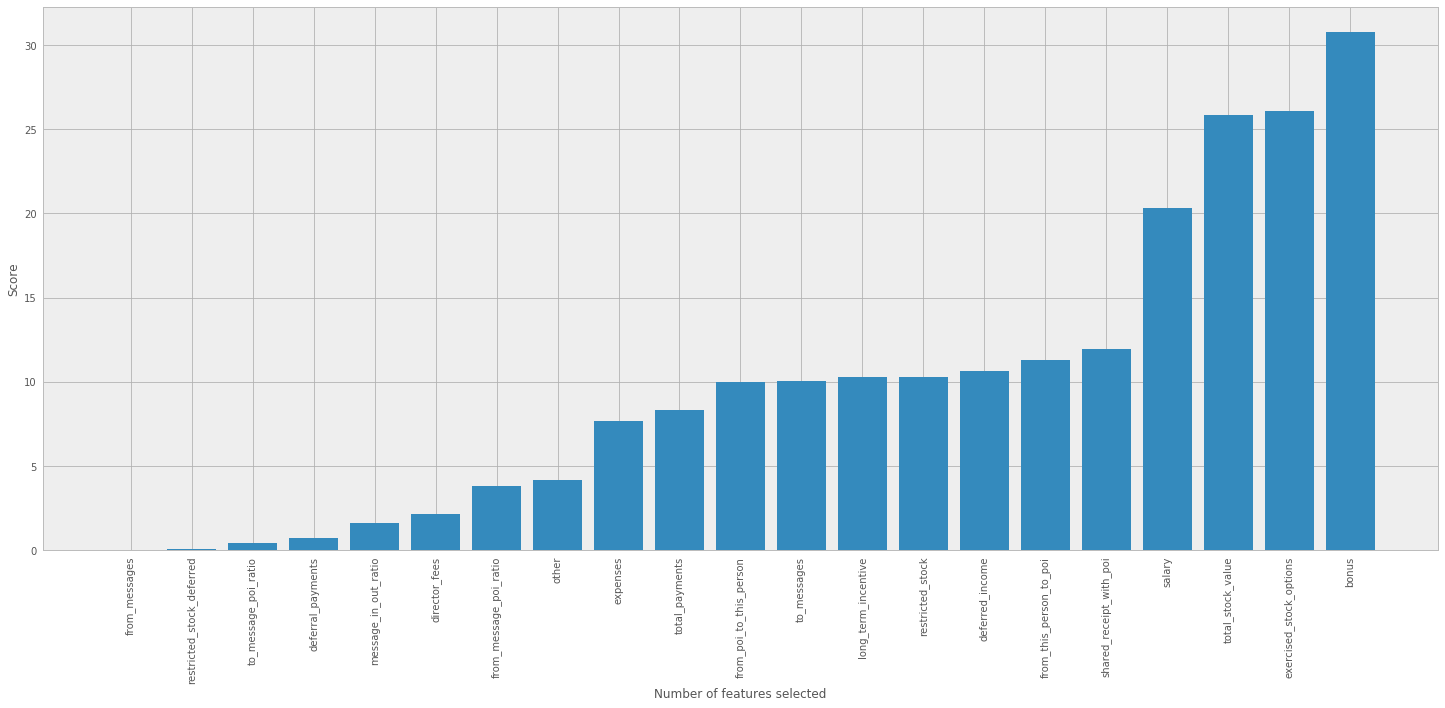

In [20]:
from sklearn.feature_selection import SelectKBest, f_classif
import collections


feature_selector = SelectKBest(f_classif, k='all')
feature_selector.fit(df_poi_filtered, target_feature)
# Get idxs of columns to keep
idxs_selected = feature_selector.get_support(indices=True)
features_dataframe_new = df_poi_filtered[idxs_selected]
print "Naive Bayes Feature Selection"
print list(features_dataframe_new)


features_dict  = dict(zip(list(df_poi_filtered), feature_selector.scores_))
features_dict = collections.OrderedDict(sorted(features_dict.items(), key=lambda t: t[1]))

plt.figure(figsize = (25,10))
plt.bar(range(len(features_dict)), features_dict.values())
plt.xlabel("Number of features selected")
plt.ylabel("Score")
plt.xticks(range(len(features_dict.keys())), features_dict.keys(), rotation=90)
plt.show()



As seen in the plot above, some features have higher scores than the others. A cut-off score need to be selected to reduce the set of features. As seen from the graph above, the score of from_messages and restricted_stock_options have very small score among others (near zero). Therefore, I select k as 19 to get rid of those features.

The selected features are below:

In [21]:
global optimal_features_naive_bayes

feature_selector = SelectKBest(f_classif, k=19)
feature_selector.fit(df_poi_filtered, target_feature)
idxs_selected = feature_selector.get_support(indices=True)
optimal_features_naive_bayes = list(df_poi_filtered[idxs_selected])
print optimal_features_naive_bayes

['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'total_stock_value', 'expenses', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'from_poi_to_this_person', 'to_message_poi_ratio', 'from_message_poi_ratio', 'message_in_out_ratio']


### Validate & Evaluate Models

Validation is an improtant process to assess how well the chosen algorithm performs. Cross validation (folded) is very important to not to overfit the data by dividing the data into train and test datasets. 

Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. Recall is the ratio of correctly predicted positive observations to the all observations in actual class. 
Accuracy is a ratio of correctly predicted observation to the total observations. 

In the context of this project, the dataset is labelled as POI and non-POI. The dataset is imbalanced, POIs are very less than non-POIs so that as a metric to compare models I have chosen precision and recall rather than accuracy. Precision Score is when the algorithm guesses that somebody is a POI, this measures how certain we are that the person really is a POI. Recall Score shows the sensitivity, among all POI users in dataset, this metric shows that the fraction of the POIs that the model can hit.

In my opinion, precision is more important than other metrics since accusing false persons is very problematic morally.

After feature selection phase for each model, those models will be evaluated for the metrics precision and recall.

In order to validate and compare my algorithms, I ran 100 randomized trials and find mean values of precision, recall and accuracy. 

##### Cross Folding

The target varible is a boolean field name poi. The dataset has 127 non-POI and 18 POI. Therefore, dataset is imbalanced. 
I want to keep the distribution of POI and non-POI on folds similar as in the dataset.  I choose StratifiedShuffleSplit as a cross folding strategy. Because, StratifiedShuffleSplit keeps the same percentage of classes as the original dataset for each fold.




In [24]:

from sklearn.metrics import classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score


def evaluate_classifier(clf, X, y):
    cv = StratifiedShuffleSplit(y, 10, random_state=42)
    print 'mean accuracy', cross_val_score(clf, X, y, cv=cv).mean()
    print 'mean precision', cross_val_score(clf, X, y, scoring=make_scorer(precision_score), cv=cv).mean()
    print 'mean recall', cross_val_score(clf, X, y, scoring=make_scorer(recall_score), cv=cv).mean()
    print 'mean f1', cross_val_score(clf, X, y, scoring=make_scorer(f1_score), cv=cv).mean()
    

def try_classifiers():
    y = df_engineered.poi
    print "GaussianNB Results"
    clf = GaussianNB()
    X = df_poi_filtered[optimal_features_naive_bayes]
    evaluate_classifier(clf, X, y)
    print
    
    print "DecisionTree Results"
    clf = DecisionTreeClassifier(random_state=42)
    X = df_poi_filtered[optimal_features_decision_tree]
    evaluate_classifier(clf, X, y)
    print
    
    print "RandomForestClassifier Results"
    clf = RandomForestClassifier(random_state=42)
    X = df_poi_filtered[optimal_features_random_forest]
    evaluate_classifier(clf, X, y)
    print
    
    
    
try_classifiers()

GaussianNB Results
mean accuracy 0.753846153846
mean precision 0.325
mean recall 0.35
mean f1 0.315

DecisionTree Results
mean accuracy 0.846153846154
mean precision 0.525
mean recall 0.55
mean f1 0.506666666667

RandomForestClassifier Results
mean accuracy 0.830769230769
mean precision 0.183333333333
mean recall 0.15
mean f1 0.156666666667



### Feature Scaling

Feature scaling was NOT needed for the models I have employed, GaussianNB does it by design. For DecisionTree and RandomForest feature scaling is not needed.


### Parameter Tuning


In the context of machine learning, hyperparameters are parameters whose values are set prior to the commencement of the learning process. By contrast, the values of other parameters are derived via training.Tuning an algorithm or machine learning technique, can be simply thought of as process which one goes through in which they optimize the parameters that impact the model in order to enable the algorithm to perform the best 

Importance of parameter tuning: One of the difficulties in learning algorithms tuning the algorithm parameters in order to get optimal results in terms of accuracy, precision and recall(as chosen metrics).  

It is important for ML algorithms to be analyzed (searched) using diferent parameters to get the best performance. For example, let's take decision tree model, it basically takes the feature space and splits them into smaller regions. In order to determine when to split the tree several parameters need to be searched and best resulting parameter set shall be used. 



In this section, GridSeachCV package of sklearn is employed to get thebest parameter options for models decision tree and random forest.


NaiveBayes results lower than Random Forest and AdaBoost models. Therefore, parameter tuninig is applied for Random Forest and Ada Boost models.

For random forest, criterion, min_samples_leaf, max_features and max_depth parameters were tried using grid search. Best results were seen in below parameter options: 

{'max_features': 6, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1}


In [26]:
from sklearn.grid_search import GridSearchCV


grid = {
    'criterion':('gini', 'entropy'),
    'min_samples_leaf':range(1, 50, 5),
    'max_features':range(1,10),
    'max_depth': range(1, 5)
}


X = df_poi_filtered[optimal_features_random_forest]
y = df_engineered.poi

search = GridSearchCV(RandomForestClassifier(random_state=42),
                      grid, make_scorer(precision_score), cv=StratifiedKFold(y, 10), n_jobs=-1)


search.fit(X, y)

print search.best_score_
print search.best_params_

evaluate_classifier(search.best_estimator_, X, y)

0.2359375
{'max_features': 6, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1}
mean accuracy 0.784615384615
mean precision 0.15
mean recall 0.1
mean f1 0.116666666667


For Decision Tree, best estimator criterion, best results were seen in below parameter options: 

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1}

In [25]:
from sklearn.grid_search import GridSearchCV
grid = {
    'criterion': ('gini', 'entropy'),
    'min_samples_leaf':range(1, 10, 5),
    'max_depth': range(1, 10)
}

print optimal_features_decision_tree
X = df_poi_filtered[optimal_features_decision_tree]
y = df_engineered.poi

search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                      grid, make_scorer(precision_score), cv=StratifiedKFold(y, 10), n_jobs=-1)


search.fit(X, y)

print search.best_score_
print search.best_params_

evaluate_classifier(search.best_estimator_, X, y)

['to_messages', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'to_message_poi_ratio']
0.3046875
{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1}
mean accuracy 0.853846153846
mean precision 0.558333333333
mean recall 0.55
mean f1 0.526666666667


### Conclusion

As a classification method, I choose Decision Tree with parameters {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1} and features ['to_messages', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'to_message_poi_ratio'] since it gave the highest precision and recall (> .3). Moreover, I choose precision as described in previous sections, the highest precision was in DecisionTree model.




tester.py results are as below:

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
            
            
        Accuracy: 0.81086       
        Precision: 0.33702      
        Recall: 0.33500 
        F1: 0.33601     
        F2: 0.33540
        Total predictions: 7000 
        True positives:  335    
        False positives:  659   
        False negatives:  665     
        True negatives: 5341